<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/02_VaR_Model_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calculating VaR and ES**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | December 20, 2025  |
|**Topics** | Market Risk Models -- HS, FHS - EWMA, GARCH (1, 1), MC |
|**Python** | OOP, Numpy, Pandas, Scienceplots, Matplotlib|
|**Sequence** | MR002 |


---

In [1]:
# Installing Packages
!pip install yfinance arch scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# plt.style.use(['science', 'notebook', 'grid'])
# plt.rcParams['text.usetex'] = True

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


# Data Preparation

In [2]:
# Quickly download the data
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['EURUSD', 'GOLD', 'GSPC', '10Y']

def calc_returns(symbols, names):
  import yfinance as yf
  import pandas as pd
  import numpy as np

  df = yf.download(symbols, start = '2020-01-01', auto_adjust= True)['Close'].dropna()
  df.columns = names
  df['10Y'] = df['10Y']/100
  df_returns = np.log(df/df.shift(1)).dropna()
  return df_returns

df_returns = calc_returns(symbols, names)
df_returns.head()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2020-01-03,-0.004411,0.016072,-0.007085,-0.051237
2020-01-06,-0.000849,0.010914,0.003527,0.012782
2020-01-07,0.003223,0.003569,-0.002807,0.008796
2020-01-08,-0.003870,-0.009204,0.004890,0.025400
2020-01-09,-0.003730,-0.003667,0.006633,-0.008574


# VaR Calculations

## Historical Simulated VaR




In [3]:
import numpy as np
import pandas as pd

def historical_var_es(df_returns, confidence_level):

  # Sort the returns in ascending order
  sorted_returns = np.sort(df_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_returns)))
  VaR = sorted_returns[var_idx]

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= VaR]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Calculating VaR and ES for each asset for different confidence levels
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
  for asset in df_returns.columns:
    var, es = historical_var_es(df_returns[asset].values, confidence_level= confidence)
    results.append({
      'Asset': asset,
      'Confidence Level': f"{confidence*100:.0f}%",
      'VaR': var,
      'ES': es,
      'Method': 'HS'
    })

df_hs_results = pd.DataFrame(results)
# df_hs_results.set_index(['Asset'], inplace= True)
df_hs_results.head()

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.005649,-0.008470,HS
1,GOLD,90%,-0.011923,-0.019904,HS
2,GSPC,90%,-0.012396,-0.023819,HS
3,10Y,90%,-0.029296,-0.058163,HS
4,EURUSD,91%,-0.005978,-0.008766,HS


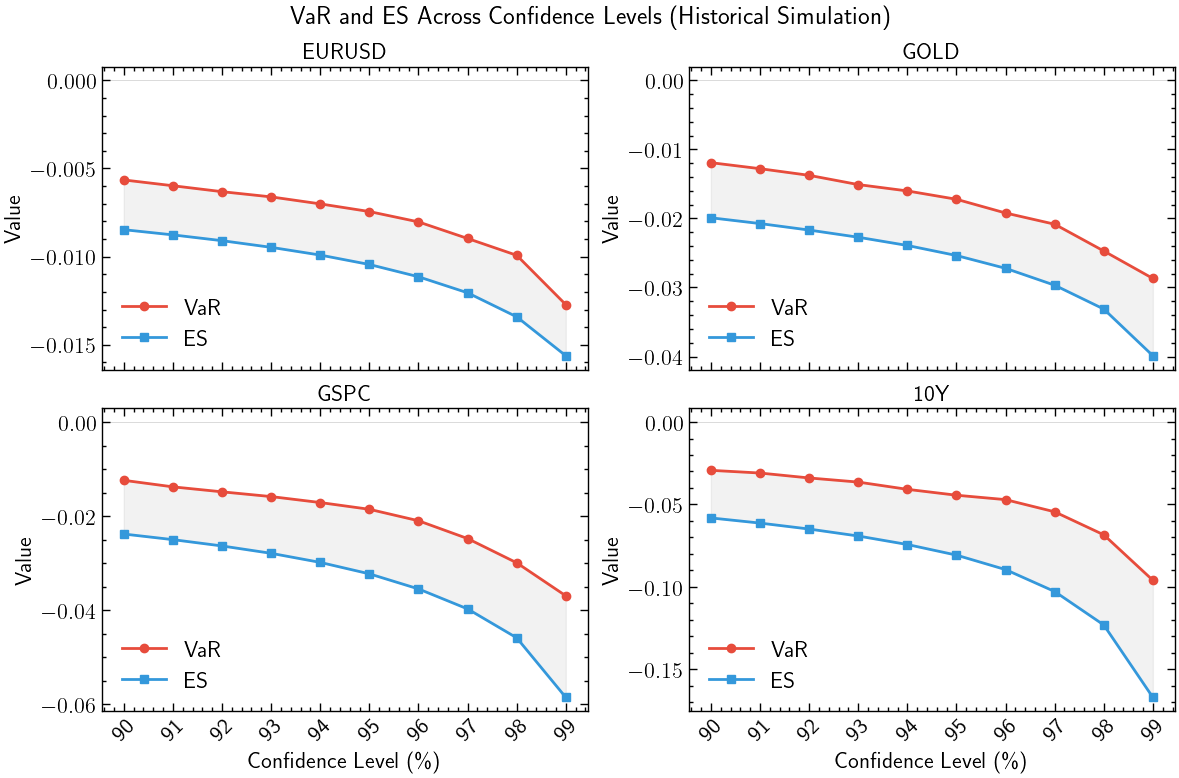

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_hs_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_hs_results[df_hs_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Historical Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

## Filtered Historical Simulated VaR

### EWMA VaR (RiskMetrics)

In [5]:
def calc_ewma_var_es_simple(df_returns, confidence_level, lambda_param=0.94):
    import numpy as np
    import pandas as pd

    # Convert to pandas Series
    if isinstance(df_returns, np.ndarray):
        returns = pd.Series(df_returns)
    else:
        returns = df_returns.copy()

    # Calculate the entire EWMA volatility series
    ewma_vol_series = np.sqrt(returns.ewm(alpha=1 - lambda_param).var())

    # Standardize returns
    standardized_returns = returns / ewma_vol_series

    # Get current volatility
    current_vol = ewma_vol_series.iloc[-1]

    # Sort the standardized returns
    sorted_z = np.sort(standardized_returns)

    # Calculate cutoff from sorted standardized returns
    var_idx = int(np.floor((1 - confidence_level) * len(sorted_z)))
    var_cutoff = sorted_z[var_idx]

    # Calculate VaR
    VaR = var_cutoff * current_vol

    # Calculate ES - IMPORTANT: compare with var_cutoff, not VaR
    es_losses = sorted_z[sorted_z <= var_cutoff]
    ES = np.mean(es_losses) * current_vol

    return VaR, ES

# Your loop with the corrected function:
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        var, es = calc_ewma_var_es_simple(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'FHS-EWMA'
        })

df_ewma_results = pd.DataFrame(results)
df_ewma_results.head()

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.003036,-0.004182,FHS-EWMA
1,GOLD,90%,-0.012823,-0.018508,FHS-EWMA
2,GSPC,90%,-0.009074,-0.013775,FHS-EWMA
3,10Y,90%,-0.009758,-0.013886,FHS-EWMA
4,EURUSD,91%,-0.003174,-0.004301,FHS-EWMA


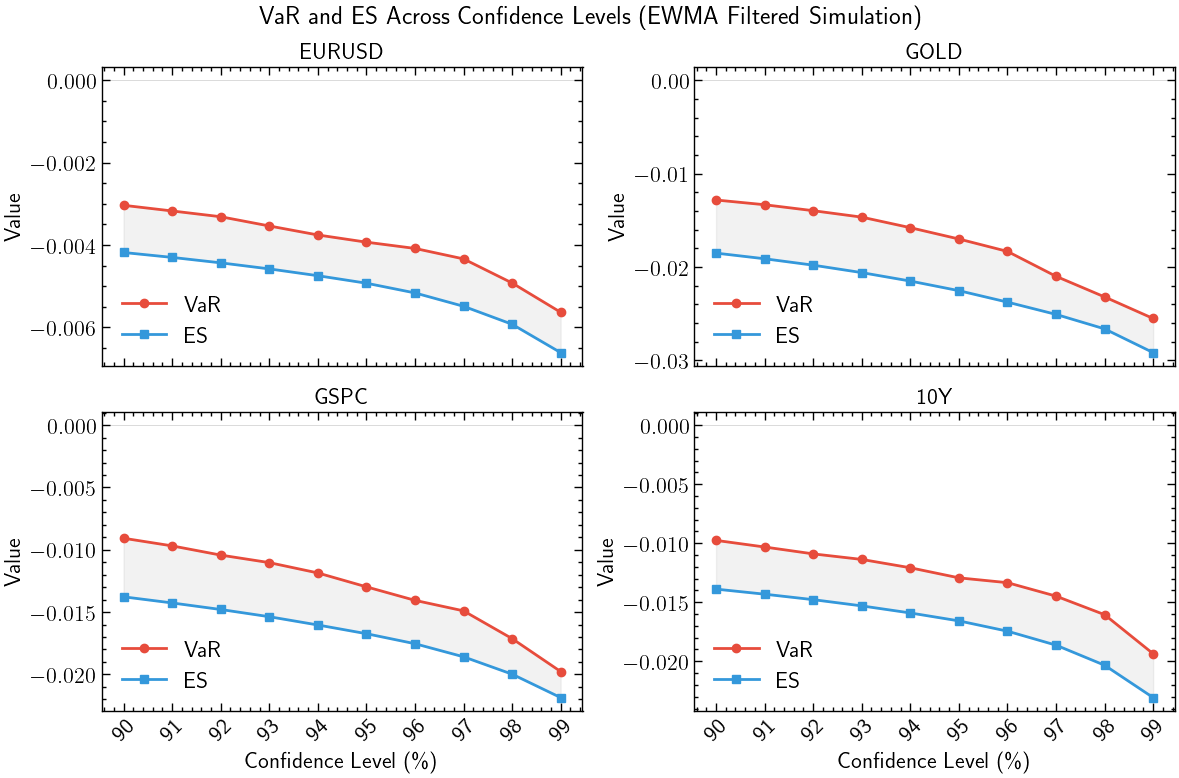

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_ewma_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_ewma_results[df_ewma_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (EWMA Filtered Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

### GARCH (1, 1) VaR

In [7]:
def calc_garch_var_es(df_returns, confidence_level):
  import numpy as np
  import pandas as pd
  from arch import arch_model

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Fit Garch(1,1) model for the sample
  model = arch_model(returns, vol='Garch', p=1, q=1, dist = 'normal')
  garch_result = model.fit(disp='off', show_warning = False)

  # Getting Standardized residuals
  standardized_residuals = garch_result.resid / garch_result.conditional_volatility
  standardized_residuals = standardized_residuals.dropna()

  # Forecast next period vol
  forecast = garch_result.forecast(horizon=1, reindex = False)
  current_vol = np.sqrt(forecast.variance.values[-1, 0])

  # Sort and calculate VaR and ES
  sorted_residuals = np.sort(standardized_residuals)
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_residuals)))
  var_cutoff = sorted_residuals[var_idx]
  VaR = var_cutoff * current_vol

  losses_beyond_var = sorted_residuals[sorted_residuals <= var_cutoff]
  ES = np.mean(losses_beyond_var) * current_vol

  return VaR, ES


# Main calculation following your exact workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        # Use the simple version for the loop
        var, es = calc_garch_var_es(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'FHS-GARCH'
        })

df_garch_fhs_results = pd.DataFrame(results)
df_garch_fhs_results.head()


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.294e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.003835,-0.005768,FHS-GARCH
1,GOLD,90%,-0.011721,-0.018205,FHS-GARCH
2,GSPC,90%,-0.010245,-0.016617,FHS-GARCH
3,10Y,90%,-0.014911,-0.022515,FHS-GARCH
4,EURUSD,91%,-0.004077,-0.005972,FHS-GARCH


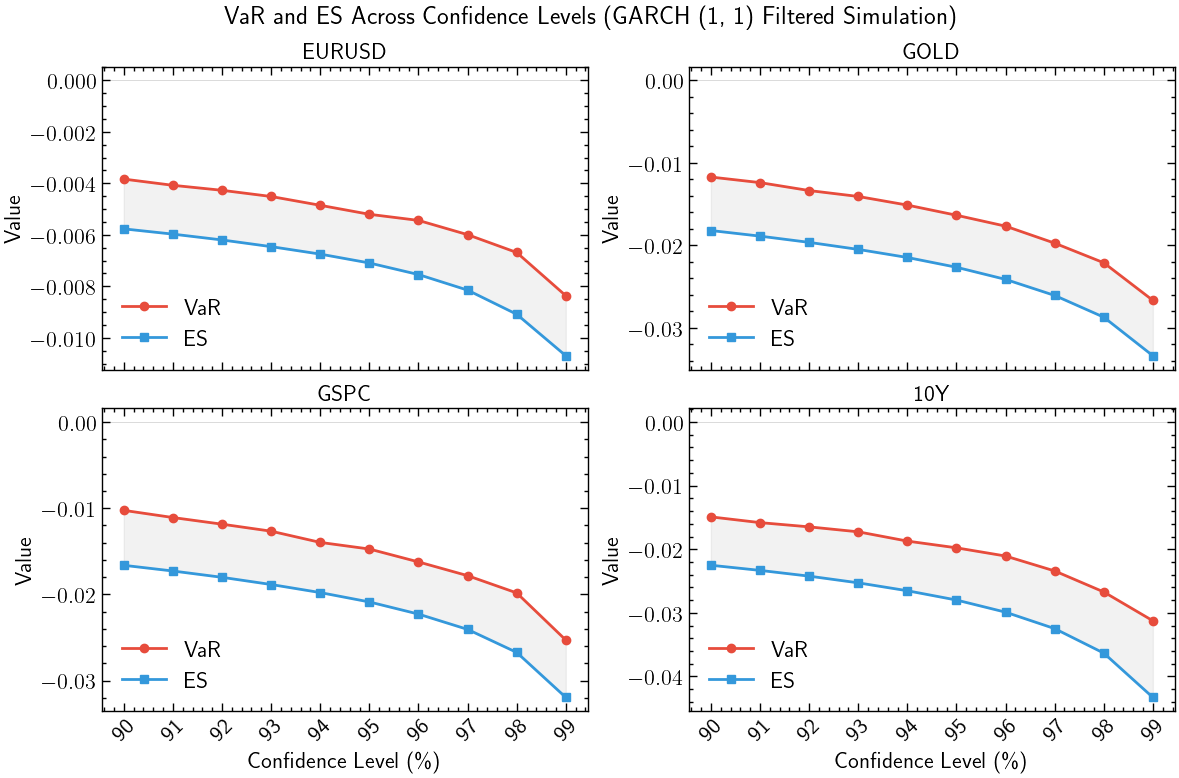

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_garch_fhs_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_garch_fhs_results[df_garch_fhs_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (GARCH (1, 1) Filtered Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

## Monte Carlo VaR

### Normal Distribution

In [9]:
def calc_monte_carlo_var_es(df_returns, confidence_level, num_simulations=1000, seed = 1212):
  import numpy as np
  import pandas as pd
  from scipy.stats import norm
  np.random.seed(seed)

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Calculate mean and standard deviation
  mean_return = returns.mean()
  std_return = returns.std()

  # Monte Carlo simulated returns (Normal Distributions)
  simulated_returns = np.random.normal(loc = mean_return, scale= std_return, size = num_simulations)

  # Sort simulated returns (ascending order, most negative first)
  sorted_returns = np.sort(simulated_returns)

  # Calculated cutoff index from sorted simulated returns
  var_idx = int(np.floor((1 - confidence_level) * num_simulations))
  var_cutoff = sorted_returns[var_idx]
  VaR = var_cutoff

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= var_cutoff]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Main calculation following your exact workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        # Use the simple version for the loop
        var, es = calc_monte_carlo_var_es(df_returns[asset], confidence_level=confidence, num_simulations=10000)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'MC-Normal'
        })

df_monte_normal_results = pd.DataFrame(results)
df_monte_normal_results.head()



,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.006116,-0.008296,MC-Normal
1,GOLD,90%,-0.013032,-0.017906,MC-Normal
2,GSPC,90%,-0.016468,-0.022485,MC-Normal
3,10Y,90%,-0.045169,-0.061380,MC-Normal
4,EURUSD,91%,-0.006402,-0.008524,MC-Normal


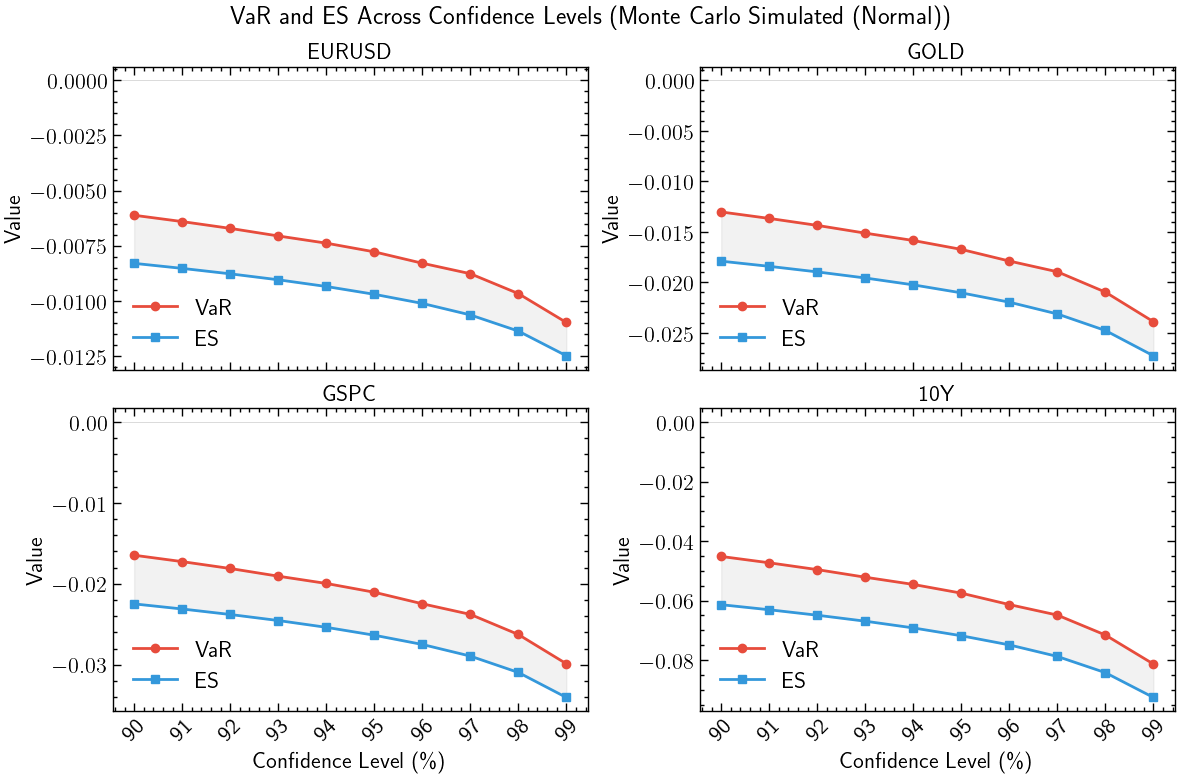

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_monte_normal_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_monte_normal_results[df_monte_normal_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Monte Carlo Simulated (Normal))', fontsize=18)
plt.tight_layout()
plt.show()

### Student t-Distribution

In [11]:
from math import degrees
def calc_monte_carlo_t_var_es(df_returns, confidence_level, num_simulations=1000, seed = 1213):
  import numpy as np
  import pandas as pd
  from scipy.stats import t

  np.random.seed(seed)

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Calculate parameters from historical returns
  mean_return = returns.mean()
  std_return = returns.std()
  df, loc, scale = t.fit(returns, method='mle')
  degrees_of_freedom = df

  # Generate Monte Carlo Simulation from t-distributions
  simulated_returns = t.rvs(df=degrees_of_freedom, loc=loc, scale=scale, size=num_simulations)

  # Sort simulated returns
  sorted_simulated_returns = np.sort(simulated_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * num_simulations))
  var_cutoff = sorted_simulated_returns[var_idx]
  VaR = var_cutoff

  # Calculate ES
  losses_beyond_var = sorted_simulated_returns[sorted_simulated_returns <= var_cutoff]
  ES = np.mean(losses_beyond_var)

  return VaR, ES, degrees_of_freedom



# Main calculation following the exact same workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

SEED = 42

for confidence in confidence_levels:
    for asset in df_returns.columns:
        var, es, df_param = calc_monte_carlo_t_var_es(
            df_returns[asset],
            confidence_level=confidence,
            num_simulations=10000,
            seed=SEED
        )
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            # 'Degrees of Freedom': df_param,
            'Method': 'MC-t',
            # 'Seed': SEED
        })

df_monte_t_results = pd.DataFrame(results)
df_monte_t_results.head()


,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.005620,-0.008534,MC-t
1,GOLD,90%,-0.010699,-0.018451,MC-t
2,GSPC,90%,-0.011504,-0.021914,MC-t
3,10Y,90%,-0.029830,-0.057132,MC-t
4,EURUSD,91%,-0.005954,-0.008841,MC-t


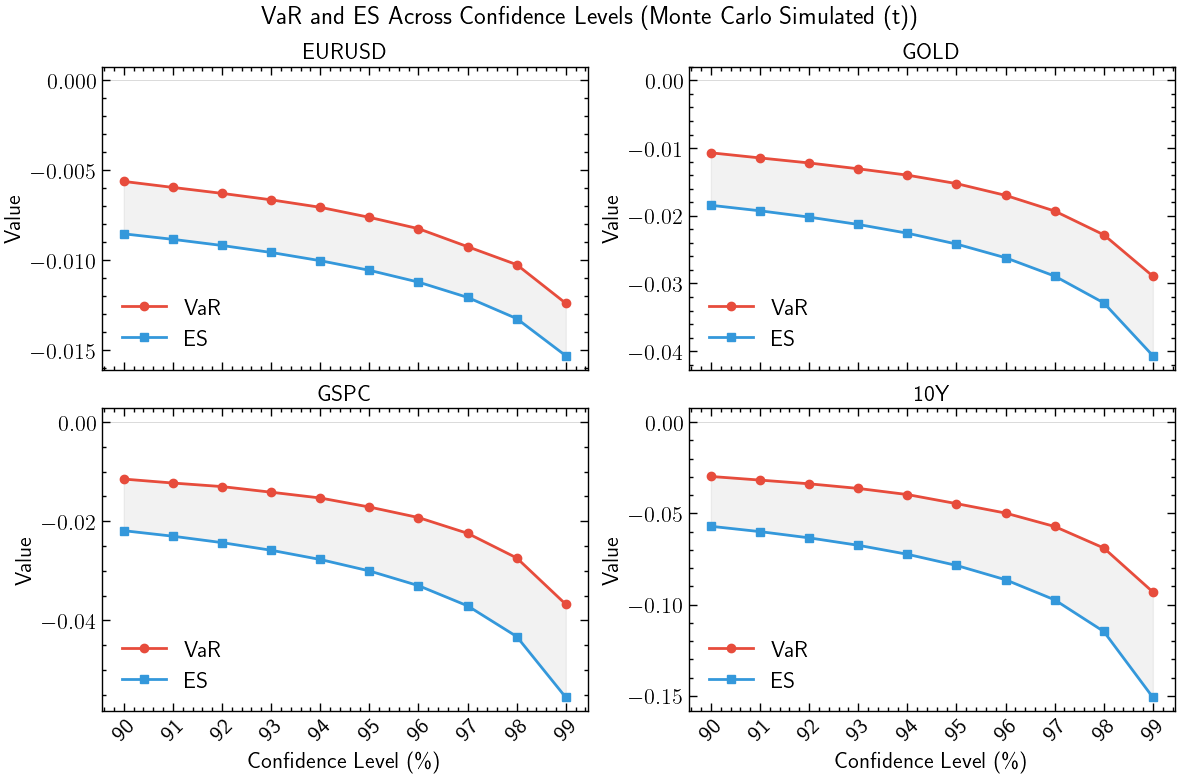

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_monte_t_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_monte_t_results[df_monte_t_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Monte Carlo Simulated (t))', fontsize=18)
plt.tight_layout()
plt.show()

# Combined Results

In [143]:
df_all_results = pd.concat([df_hs_results, df_garch_fhs_results, df_ewma_results, df_monte_normal_results, df_monte_t_results], axis=0)
display(df_all_results)

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.005649,-0.008470,HS
1,GOLD,90%,-0.011923,-0.019904,HS
2,GSPC,90%,-0.012396,-0.023819,HS
3,10Y,90%,-0.029296,-0.058163,HS
4,EURUSD,91%,-0.005978,-0.008766,HS
...,...,...,...,...,...
35,10Y,98%,-0.069029,-0.114759,MC-t
36,EURUSD,99%,-0.012397,-0.015314,MC-t
37,GOLD,99%,-0.028926,-0.040675,MC-t
38,GSPC,99%,-0.036762,-0.055538,MC-t


## Summarising Results

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# First, let's create a summary table
summary_table = df_all_results.groupby(['Method', 'Confidence Level']).agg({
    'VaR': ['mean', 'std', 'min', 'max'],
    'ES': ['mean', 'std', 'min', 'max']
}).round(6)

display(summary_table)

# If you have multiple assets, compare by asset
if 'Asset' in df_all_results.columns:
    asset_comparison = df_all_results.pivot_table(
        index=['Asset', 'Confidence Level'],
        columns='Method',
        values=['VaR', 'ES']
    ).round(6)
    display(asset_comparison)

VaR                                      ES  \
                                mean       std       min       max      mean   
Method    Confidence Level                                                     
FHS-EWMA  90%              -0.008673  0.004096 -0.012823 -0.003036 -0.012588   
          91%              -0.009128  0.004276 -0.013330 -0.003174 -0.012999   
          92%              -0.009652  0.004508 -0.013968 -0.003314 -0.013451   
          93%              -0.010149  0.004701 -0.014658 -0.003538 -0.013963   
          94%              -0.010870  0.005073 -0.015786 -0.003756 -0.014547   
          95%              -0.011708  0.005525 -0.016998 -0.003931 -0.015192   
          96%              -0.012452  0.005998 -0.018326 -0.004083 -0.015976   
          97%              -0.013677  0.006901 -0.020990 -0.004337 -0.016944   
          98%              -0.015325  0.007615 -0.023197 -0.004922 -0.018215   
          99%              -0.017567  0.008437 -0.025506 -0.005632 -0.020176   
FHS-GARCH 90%              -0.010178  0.004656 -0.014911 -0.003835 -0.015776   
          91%              -0.010841  0.004932 -0.015814 -0.004077 -0.016365   
          92%              -0.011489  0.005185 -0.016481 -0.004270 -0.017019   
          93%              -0.012127  0.005429 -0.017260 -0.004511 -0.017769   
          94%              -0.013164  0.005899 -0.018719 -0.004853 -0.018631   
          95%              -0.014015  0.006240 -0.019776 -0.005202 -0.019650   
          96%              -0.015102  0.006753 -0.021067 -0.005440 -0.020960   
          97%              -0.016740  0.007531 -0.023413 -0.005994 -0.022688   
          98%              -0.018834  0.008591 -0.026716 -0.006686 -0.025211   
          99%              -0.022894  0.010015 -0.031248 -0.008365 -0.029829   
HS        90%              -0.014816  0.010132 -0.029296 -0.005649 -0.027589   
          91%              -0.015874  0.010624 -0.030936 -0.005978 -0.028952   
          92%              -0.017210  0.011770 -0.033923 -0.006314 -0.030508   
          93%              -0.018496  0.012664 -0.036422 -0.006610 -0.032311   
          94%              -0.020242  0.014449 -0.040822 -0.007007 -0.034489   
          95%              -0.021905  0.015789 -0.044391 -0.007442 -0.037203   
          96%              -0.023827  0.016523 -0.047068 -0.008029 -0.040838   
          97%              -0.027262  0.019334 -0.054455 -0.008970 -0.046063   
          98%              -0.033245  0.024924 -0.068403 -0.009923 -0.053875   
          99%              -0.043595  0.036358 -0.096003 -0.012723 -0.070273   
MC-Normal 90%              -0.020196  0.017196 -0.045169 -0.006116 -0.027517   
          91%              -0.021158  0.018002 -0.047298 -0.006402 -0.028282   
          92%              -0.022193  0.018871 -0.049590 -0.006710 -0.029111   
          93%              -0.023346  0.019838 -0.052145 -0.007054 -0.030017   
          94%              -0.024440  0.020756 -0.054567 -0.007380 -0.031038   
          95%              -0.025764  0.021867 -0.057499 -0.007774 -0.032227   
          96%              -0.027497  0.023320 -0.061336 -0.008290 -0.033615   
          97%              -0.029092  0.024658 -0.064867 -0.008765 -0.035365   
          98%              -0.032116  0.027195 -0.071564 -0.009666 -0.037825   
          99%              -0.036516  0.030886 -0.081308 -0.010976 -0.041585   
MC-t      90%              -0.014413  0.010603 -0.029830 -0.005620 -0.026508   
          91%              -0.015382  0.011311 -0.031814 -0.005954 -0.027797   
          92%              -0.016338  0.012053 -0.033848 -0.006285 -0.029292   
          93%              -0.017562  0.012980 -0.036387 -0.006644 -0.031062   
          94%              -0.019029  0.014275 -0.039741 -0.007059 -0.033194   
          95%              -0.021179  0.016219 -0.044712 -0.007617 -0.035832   
          96%              -0.023597  0.018159 -0.049888 -0.008248 -0.039208   
          97%              -0.027

ES                                          \
Method                   FHS-EWMA FHS-GARCH        HS MC-Normal      MC-t   
Asset  Confidence Level                                                     
10Y    90%              -0.013886 -0.022515 -0.058163 -0.061380 -0.057132   
       91%              -0.014315 -0.023325 -0.061286 -0.063075 -0.060053   
       92%              -0.014779 -0.024229 -0.064900 -0.064911 -0.063464   
       93%              -0.015306 -0.025280 -0.069127 -0.066917 -0.067533   
       94%              -0.015905 -0.026523 -0.074279 -0.069177 -0.072457   
       95%              -0.016576 -0.027984 -0.080712 -0.071810 -0.078563   
       96%              -0.017447 -0.029893 -0.089492 -0.074884 -0.086418   
       97%              -0.018631 -0.032477 -0.102785 -0.078760 -0.097429   
       98%              -0.020333 -0.036329 -0.123068 -0.084208 -0.114759   
       99%              -0.023073 -0.043295 -0.167013 -0.092533 -0.150895   
EURUSD 90%              -0.004182 -0.005768 -0.008470 -0.008296 -0.008534   
       91%              -0.004301 -0.005972 -0.008766 -0.008524 -0.008841   
       92%              -0.004433 -0.006199 -0.009094 -0.008771 -0.009182   
       93%              -0.004580 -0.006459 -0.009472 -0.009041 -0.009571   
       94%              -0.004745 -0.006749 -0.009910 -0.009345 -0.010027   
       95%              -0.004927 -0.007093 -0.010445 -0.009699 -0.010562   
       96%              -0.005163 -0.007543 -0.011141 -0.010112 -0.011219   
       97%              -0.005487 -0.008148 -0.012050 -0.010633 -0.012070   
       98%              -0.005923 -0.009085 -0.013413 -0.011366 -0.013247   
       99%              -0.006612 -0.010697 -0.015622 -0.012485 -0.015314   
GOLD   90%              -0.018508 -0.018205 -0.019904 -0.017906 -0.018451   
       91%              -0.019113 -0.018884 -0.020744 -0.018416 -0.019266   
       92%              -0.019798 -0.019641 -0.021684 -0.018967 -0.020198   
       93%              -0.020596 -0.020494 -0.022724 -0.019571 -0.021284   
       94%              -0.021500 -0.021472 -0.023916 -0.020250 -0.022573   
       95%              -0.022528 -0.022657 -0.025371 -0.021042 -0.024175   
       96%              -0.023755 -0.024130 -0.027227 -0.021965 -0.026200   
       97%              -0.025069 -0.026075 -0.029673 -0.023131 -0.028906   
       98%              -0.026618 -0.028711 -0.033128 -0.024768 -0.032865   
       99%              -0.029158 -0.033387 -0.039892 -0.027271 -0.040675   
GSPC   90%              -0.013775 -0.016617 -0.023819 -0.022485 -0.021914   
       91%              -0.014268 -0.017279 -0.025012 -0.023114 -0.023028   
       92%              -0.014793 -0.018010 -0.026354 -0.023796 -0.024323   
       93%              -0.015372 -0.018844 -0.027920 -0.024541 -0.025860   
       94%              -0.016036 -0.019779 -0.029852 -0.025379 -0.027720   
       95%              -0.016736 -0.020866 -0.032282 -0.026357 -0.030029   
       96%              -0.017539 -0.022275 -0.035493 -0.027498 -0.032997   
       97%              -0.018590 -0.024050 -0.039745 -0.028936 -0.037069   
       98%              -0.019984 -0.026719 -0.045889 -0.030958 -0.043258   
       99%              -0.021863 -0.031939 -0.058565 -0.034049 -0.055538   

                              VaR                                          
Method                   FHS-EWMA FHS-GARCH        HS MC-Normal      MC-t  
Asset  Confidence Level                                                    
10Y    90%              -0.009758 -0.014911 -0.029296 -0.045169 -0.029830  
       91%              -0.010319 -0.015814 -0.030936 -0.047298 -0.031814  
       92%              -0.010901 -0.016481 -0.033923 -0.049590 -0.033848  
       93%              -0.011371 -0.017260 -0.036422 -0.052145 -0.036387  
       94%              -0.012077 -0.018719 -0.040822 -0.054567 -0.039741  
       95%              -0.012931 -0.019776 -0.044391 -0.057499 -0.044712  
       96%              -0.013340 -

## Performance Analysis (Method Ranking)

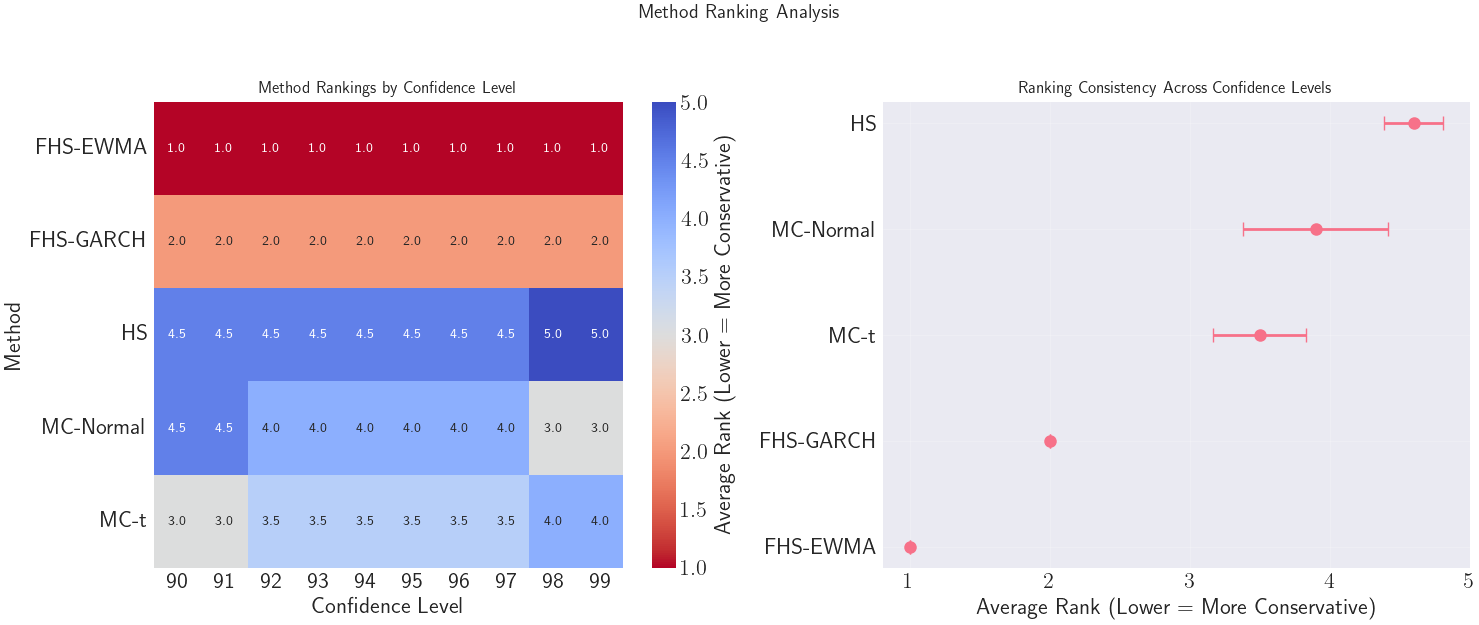


Rankings for Confidence Level: 90%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.008673,1,-0.012588,1.0,90%
1,FHS-GARCH,2,-0.010178,2,-0.015776,2.0,90%
2,MC-t,3,-0.014413,3,-0.026508,3.0,90%
3,HS,4,-0.014816,5,-0.027589,4.5,90%
4,MC-Normal,5,-0.020196,4,-0.027517,4.5,90%



Rankings for Confidence Level: 91%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.009128,1,-0.012999,1.0,91%
1,FHS-GARCH,2,-0.010841,2,-0.016365,2.0,91%
2,MC-t,3,-0.015382,3,-0.027797,3.0,91%
3,HS,4,-0.015874,5,-0.028952,4.5,91%
4,MC-Normal,5,-0.021158,4,-0.028282,4.5,91%



Rankings for Confidence Level: 92%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.009652,1,-0.013451,1.0,92%
1,FHS-GARCH,2,-0.011489,2,-0.017019,2.0,92%
2,MC-t,3,-0.016338,4,-0.029292,3.5,92%
4,MC-Normal,5,-0.022193,3,-0.029111,4.0,92%
3,HS,4,-0.017210,5,-0.030508,4.5,92%



Rankings for Confidence Level: 93%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.010149,1,-0.013963,1.0,93%
1,FHS-GARCH,2,-0.012127,2,-0.017769,2.0,93%
2,MC-t,3,-0.017562,4,-0.031062,3.5,93%
4,MC-Normal,5,-0.023346,3,-0.030017,4.0,93%
3,HS,4,-0.018496,5,-0.032311,4.5,93%



Rankings for Confidence Level: 94%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.010870,1,-0.014547,1.0,94%
1,FHS-GARCH,2,-0.013164,2,-0.018631,2.0,94%
2,MC-t,3,-0.019029,4,-0.033194,3.5,94%
4,MC-Normal,5,-0.024440,3,-0.031038,4.0,94%
3,HS,4,-0.020242,5,-0.034489,4.5,94%



Rankings for Confidence Level: 95%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.011708,1,-0.015192,1.0,95%
1,FHS-GARCH,2,-0.014015,2,-0.019650,2.0,95%
2,MC-t,3,-0.021179,4,-0.035832,3.5,95%
4,MC-Normal,5,-0.025764,3,-0.032227,4.0,95%
3,HS,4,-0.021905,5,-0.037203,4.5,95%



Rankings for Confidence Level: 96%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.012452,1,-0.015976,1.0,96%
1,FHS-GARCH,2,-0.015102,2,-0.020960,2.0,96%
2,MC-t,3,-0.023597,4,-0.039208,3.5,96%
4,MC-Normal,5,-0.027497,3,-0.033615,4.0,96%
3,HS,4,-0.023827,5,-0.040838,4.5,96%



Rankings for Confidence Level: 97%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.013677,1,-0.016944,1.0,97%
1,FHS-GARCH,2,-0.016740,2,-0.022688,2.0,97%
2,MC-t,3,-0.027059,4,-0.043868,3.5,97%
4,MC-Normal,5,-0.029092,3,-0.035365,4.0,97%
3,HS,4,-0.027262,5,-0.046063,4.5,97%



Rankings for Confidence Level: 98%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.015325,1,-0.018215,1.0,98%
1,FHS-GARCH,2,-0.018834,2,-0.025211,2.0,98%
2,MC-Normal,3,-0.032116,3,-0.037825,3.0,98%
3,MC-t,4,-0.032373,4,-0.051032,4.0,98%
4,HS,5,-0.033245,5,-0.053875,5.0,98%



Rankings for Confidence Level: 99%


,Method,VaR_Rank,VaR_Value,ES_Rank,ES_Value,Average_Rank,Confidence_Level
0,FHS-EWMA,1,-0.017567,1,-0.020176,1.0,99%
1,FHS-GARCH,2,-0.022894,2,-0.029829,2.0,99%
2,MC-Normal,3,-0.036516,3,-0.041585,3.0,99%
3,MC-t,4,-0.042805,4,-0.065605,4.0,99%
4,HS,5,-0.043595,5,-0.070273,5.0,99%


In [145]:
def analyze_rankings(df_all_results):
    """Analyze and visualize method rankings"""

    # Calculate rankings for each confidence level
    rankings = {}
    for conf_level in df_all_results['Confidence Level'].unique():
        conf_data = df_all_results[df_all_results['Confidence Level'] == conf_level]

        # Rank by VaR (higher VaR = more conservative)
        var_ranking = conf_data.groupby('Method')['VaR'].mean().sort_values(ascending=False)
        var_ranking_df = pd.DataFrame({
            'Method': var_ranking.index,
            'VaR_Rank': range(1, len(var_ranking) + 1),
            'VaR_Value': var_ranking.values
        })

        # Rank by ES (higher ES = more conservative)
        es_ranking = conf_data.groupby('Method')['ES'].mean().sort_values(ascending=False)
        es_ranking_df = pd.DataFrame({
            'Method': es_ranking.index,
            'ES_Rank': range(1, len(es_ranking) + 1),
            'ES_Value': es_ranking.values
        })

        # Combine rankings
        combined_rank = pd.merge(var_ranking_df, es_ranking_df, on='Method')
        combined_rank['Average_Rank'] = (combined_rank['VaR_Rank'] + combined_rank['ES_Rank']) / 2
        combined_rank['Confidence_Level'] = conf_level

        rankings[conf_level] = combined_rank

    # Create ranking visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Ranking heatmap
    all_ranks = pd.concat(rankings.values())
    rank_pivot = all_ranks.pivot_table(
        index='Method',
        columns='Confidence_Level',
        values='Average_Rank'
    )

    sns.heatmap(rank_pivot, annot=True, fmt='.1f', cmap='coolwarm_r',
                ax=axes[0], cbar_kws={'label': 'Average Rank (Lower = More Conservative)'})
    axes[0].set_title('Method Rankings by Confidence Level', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Confidence Level')
    axes[0].set_ylabel('Method')

    # Ranking consistency plot
    rank_consistency = all_ranks.groupby('Method')['Average_Rank'].agg(['mean', 'std'])
    rank_consistency = rank_consistency.sort_values('mean')

    axes[1].errorbar(rank_consistency['mean'], range(len(rank_consistency)),
                    xerr=rank_consistency['std'], fmt='o', capsize=5, markersize=8)
    axes[1].set_yticks(range(len(rank_consistency)))
    axes[1].set_yticklabels(rank_consistency.index)
    axes[1].set_xlabel('Average Rank (Lower = More Conservative)')
    axes[1].set_title('Ranking Consistency Across Confidence Levels', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Method Ranking Analysis', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

    # Display ranking tables
    for conf_level, rank_df in rankings.items():
        print(f"\n{'='*60}")
        print(f"Rankings for Confidence Level: {conf_level}")
        print('='*60)
        display(rank_df.sort_values('Average_Rank'))

    return rankings

rankings = analyze_rankings(df_all_results)

## Heatmap Comparison

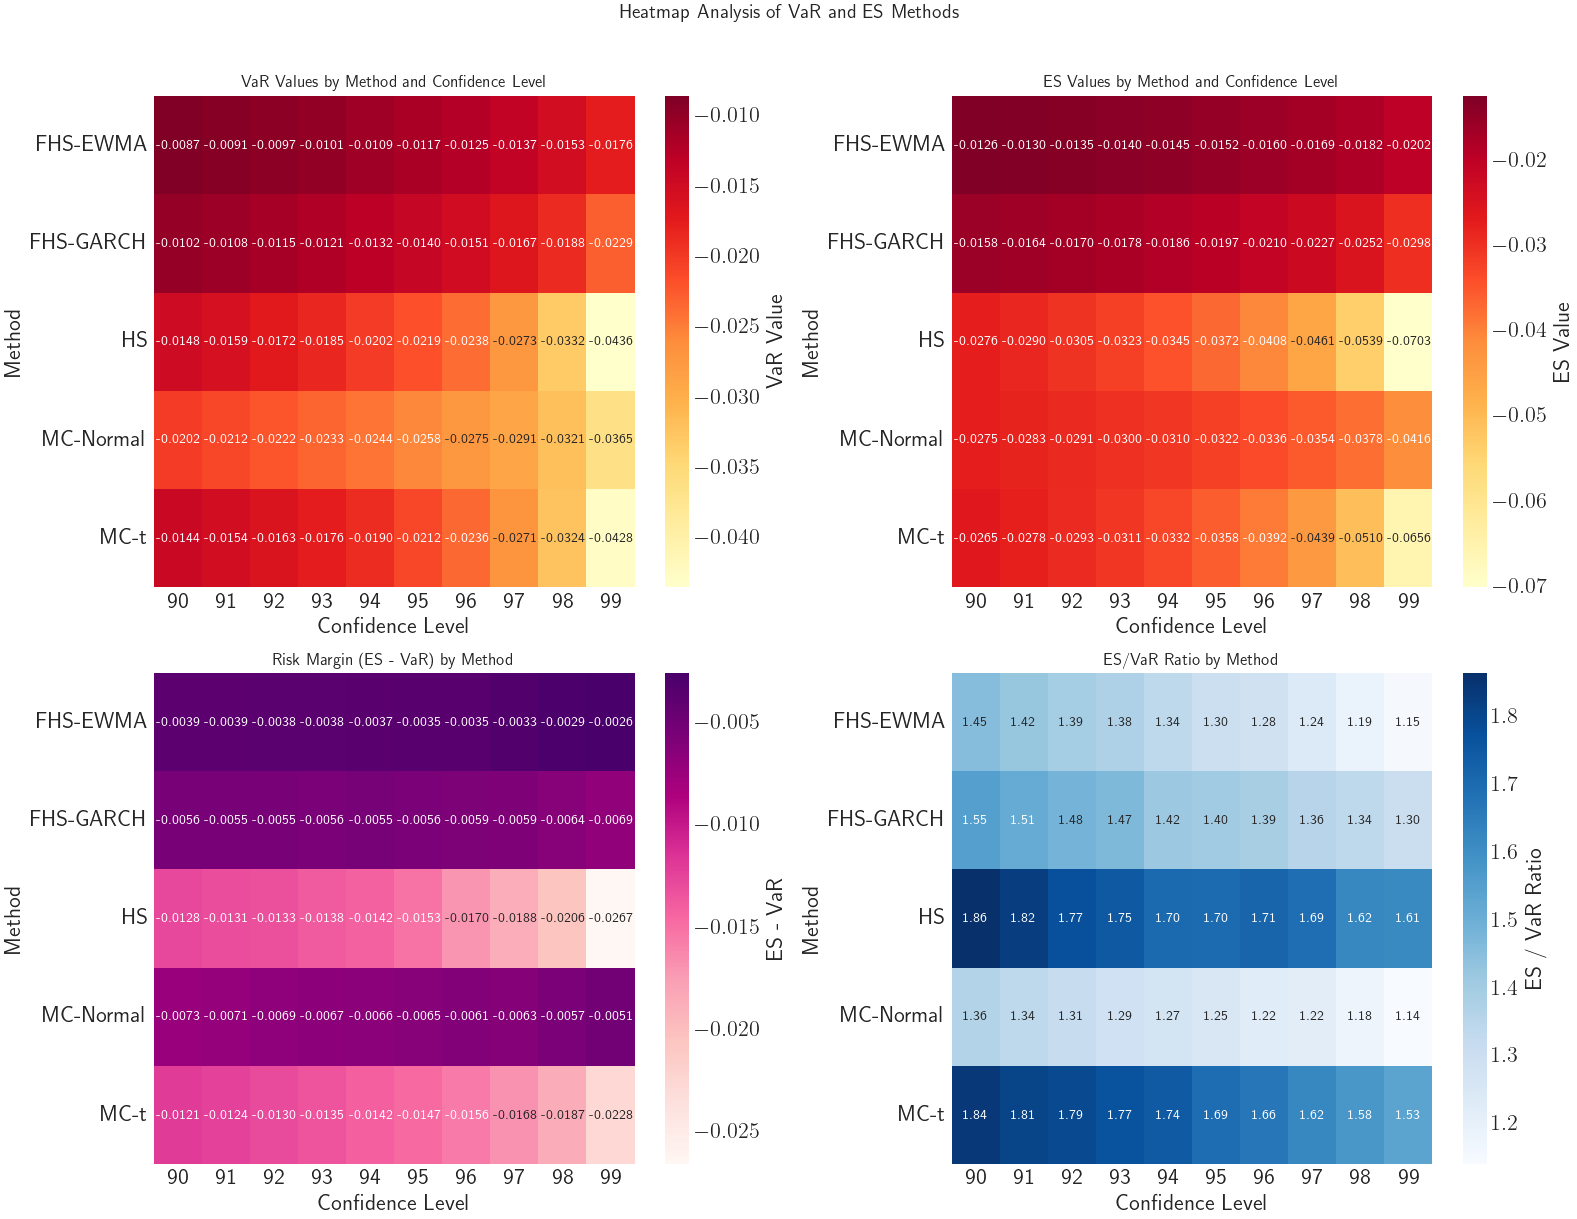

In [146]:
def plot_heatmap_comparisons(df_all_results):
    """Create heatmap visualizations for easy comparison"""
    # Pivot the data for heatmaps
    var_pivot = df_all_results.pivot_table(
        index='Method',
        columns='Confidence Level',
        values='VaR',
        aggfunc='mean'
    )

    es_pivot = df_all_results.pivot_table(
        index='Method',
        columns='Confidence Level',
        values='ES',
        aggfunc='mean'
    )

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. VaR Heatmap
    sns.heatmap(var_pivot, annot=True, fmt='.4f', cmap='YlOrRd',
                ax=axes[0, 0], cbar_kws={'label': 'VaR Value'})
    axes[0, 0].set_title('VaR Values by Method and Confidence Level', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Confidence Level')
    axes[0, 0].set_ylabel('Method')

    # 2. ES Heatmap
    sns.heatmap(es_pivot, annot=True, fmt='.4f', cmap='YlOrRd',
                ax=axes[0, 1], cbar_kws={'label': 'ES Value'})
    axes[0, 1].set_title('ES Values by Method and Confidence Level', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Confidence Level')
    axes[0, 1].set_ylabel('Method')

    # 3. Difference between ES and VaR (Risk Margin)
    risk_margin_pivot = es_pivot - var_pivot
    sns.heatmap(risk_margin_pivot, annot=True, fmt='.4f', cmap='RdPu',
                ax=axes[1, 0], cbar_kws={'label': 'ES - VaR'})
    axes[1, 0].set_title('Risk Margin (ES - VaR) by Method', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Confidence Level')
    axes[1, 0].set_ylabel('Method')

    # 4. Ratio of ES to VaR
    ratio_pivot = es_pivot / var_pivot
    sns.heatmap(ratio_pivot, annot=True, fmt='.2f', cmap='Blues',
                ax=axes[1, 1], cbar_kws={'label': 'ES / VaR Ratio'})
    axes[1, 1].set_title('ES/VaR Ratio by Method', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Confidence Level')
    axes[1, 1].set_ylabel('Method')

    plt.suptitle('Heatmap Analysis of VaR and ES Methods', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_heatmap_comparisons(df_all_results)

## Statistical Comparison

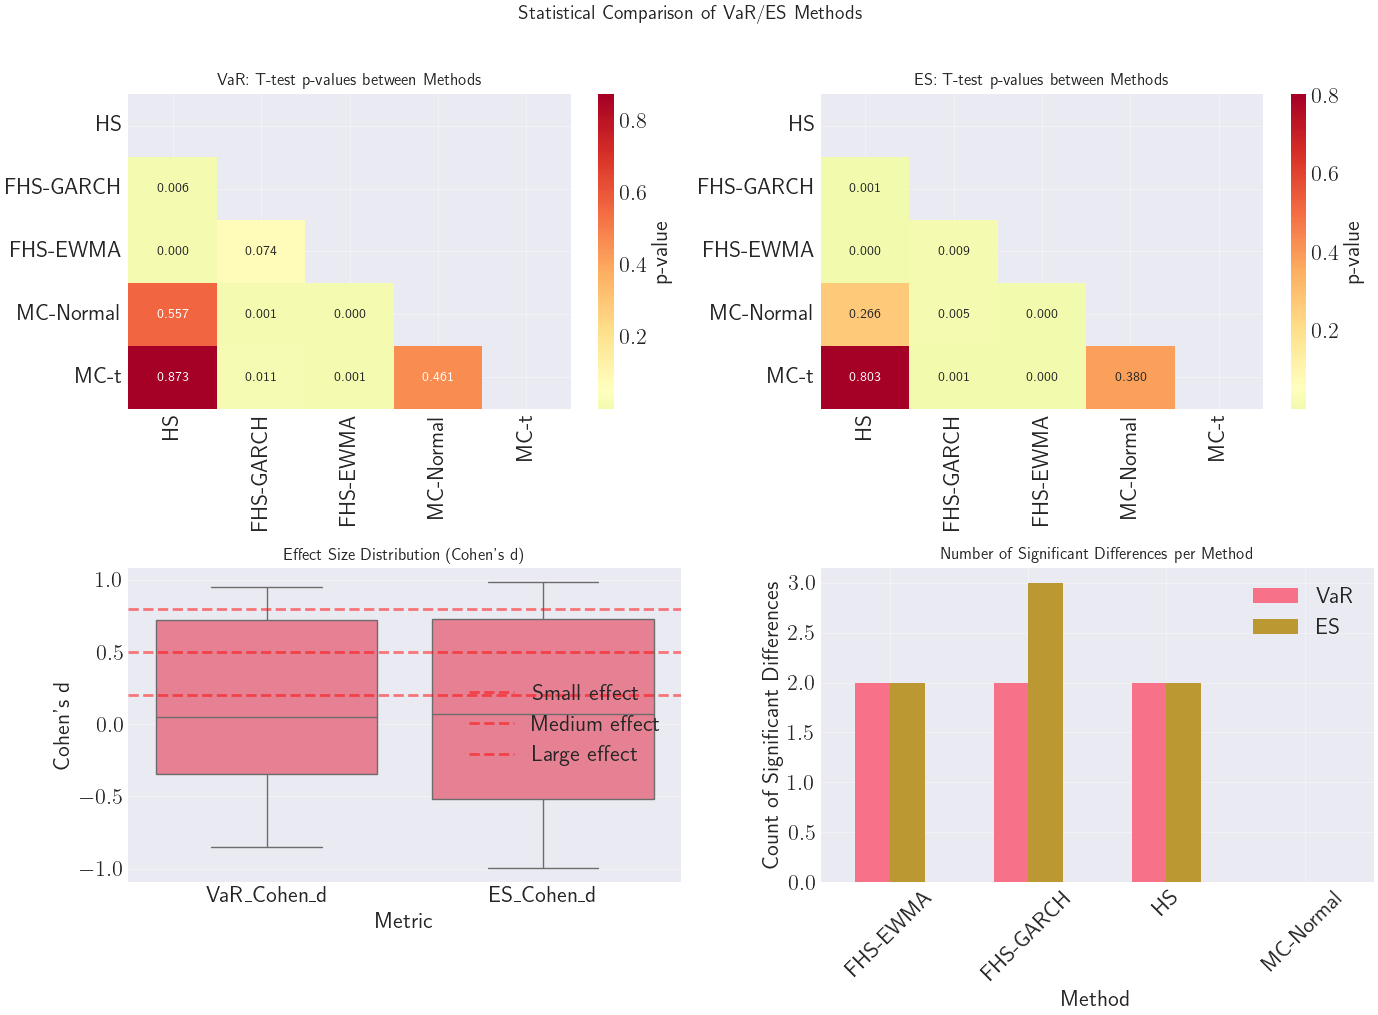

,Method1,Method2,VaR_Difference,ES_Difference,VaR_Ttest_p,ES_Ttest_p,VaR_Wilcoxon_p,ES_Wilcoxon_p,VaR_Cohen_d,ES_Cohen_d,Significant_VaR,Significant_ES
0,HS,FHS-GARCH,-0.0091,-0.0198,0.0057,0.0011,0.0319,0.0027,-0.6458,-0.7825,True,True
1,HS,FHS-EWMA,-0.0117,-0.0248,0.0004,0.0001,0.0007,0.0000,-0.8479,-0.9943,True,True
2,HS,MC-Normal,0.0026,-0.0076,0.5568,0.2657,0.5834,0.2812,0.1320,-0.2509,False,False
3,HS,MC-t,-0.0007,-0.0019,0.8729,0.8031,0.6932,0.7802,-0.0359,-0.0560,False,False
4,FHS-GARCH,FHS-EWMA,-0.0026,-0.0050,0.0745,0.0085,0.0519,0.0027,-0.4044,-0.6045,False,True
5,FHS-GARCH,MC-Normal,0.0117,0.0123,0.0013,0.0052,0.0105,0.0735,0.7642,0.6540,True,True
6,FHS-GARCH,MC-t,0.0084,0.0180,0.0108,0.0015,0.1060,0.0084,0.5924,0.7567,True,True
7,FHS-EWMA,MC-Normal,0.0143,0.0173,0.0001,0.0001,0.0002,0.0002,0.9508,0.9458,True,True
8,FHS-EWMA,MC-t,0.0111,0.0229,0.0009,0.0001,0.0045,0.0000,0.7912,0.9838,True,True
9,MC-Normal,MC-t,-0.0033,0.0057,0.4614,0.3799,0.3812,0.4471,-0.1655,0.1975,False,False


In [147]:
from scipy import stats

def statistical_comparison(df_all_results):
    """Perform statistical tests to compare methods"""

    results_summary = []

    # Compare each pair of methods
    methods = df_all_results['Method'].unique()
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]

            # Extract VaR values for both methods
            var1 = df_all_results[df_all_results['Method'] == method1]['VaR'].values
            var2 = df_all_results[df_all_results['Method'] == method2]['VaR'].values

            # Extract ES values for both methods
            es1 = df_all_results[df_all_results['Method'] == method1]['ES'].values
            es2 = df_all_results[df_all_results['Method'] == method2]['ES'].values

            # Statistical tests
            # T-test for means
            t_stat_var, p_val_var = stats.ttest_ind(var1, var2, equal_var=False)
            t_stat_es, p_val_es = stats.ttest_ind(es1, es2, equal_var=False)

            # Wilcoxon rank-sum test (non-parametric)
            w_stat_var, wp_val_var = stats.ranksums(var1, var2)
            w_stat_es, wp_val_es = stats.ranksums(es1, es2)

            # Effect size (Cohen's d)
            def cohens_d(x, y):
                nx = len(x)
                ny = len(y)
                dof = nx + ny - 2
                return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

            d_var = cohens_d(var1, var2)
            d_es = cohens_d(es1, es2)

            results_summary.append({
                'Method1': method1,
                'Method2': method2,
                'VaR_Difference': np.mean(var1) - np.mean(var2),
                'ES_Difference': np.mean(es1) - np.mean(es2),
                'VaR_Ttest_p': p_val_var,
                'ES_Ttest_p': p_val_es,
                'VaR_Wilcoxon_p': wp_val_var,
                'ES_Wilcoxon_p': wp_val_es,
                'VaR_Cohen_d': d_var,
                'ES_Cohen_d': d_es,
                'Significant_VaR': p_val_var < 0.05,
                'Significant_ES': p_val_es < 0.05
            })

    # Create results DataFrame
    stats_df = pd.DataFrame(results_summary)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # P-value heatmap for VaR
    pval_matrix_var = pd.DataFrame(index=methods, columns=methods)
    for _, row in stats_df.iterrows():
        pval_matrix_var.loc[row['Method1'], row['Method2']] = row['VaR_Ttest_p']
        pval_matrix_var.loc[row['Method2'], row['Method1']] = row['VaR_Ttest_p']
    np.fill_diagonal(pval_matrix_var.values, 1)

    mask = np.triu(np.ones_like(pval_matrix_var, dtype=bool))
    sns.heatmap(pval_matrix_var.astype(float), annot=True, fmt='.3f',
                mask=mask, cmap='RdYlGn_r', center=0.05,
                ax=axes[0, 0], cbar_kws={'label': 'p-value'})
    axes[0, 0].set_title('VaR: T-test p-values between Methods', fontsize=12, fontweight='bold')

    # P-value heatmap for ES
    pval_matrix_es = pd.DataFrame(index=methods, columns=methods)
    for _, row in stats_df.iterrows():
        pval_matrix_es.loc[row['Method1'], row['Method2']] = row['ES_Ttest_p']
        pval_matrix_es.loc[row['Method2'], row['Method1']] = row['ES_Ttest_p']
    np.fill_diagonal(pval_matrix_es.values, 1)

    sns.heatmap(pval_matrix_es.astype(float), annot=True, fmt='.3f',
                mask=mask, cmap='RdYlGn_r', center=0.05,
                ax=axes[0, 1], cbar_kws={'label': 'p-value'})
    axes[0, 1].set_title('ES: T-test p-values between Methods', fontsize=12, fontweight='bold')

    # Effect size comparison
    effect_sizes = stats_df[['Method1', 'Method2', 'VaR_Cohen_d', 'ES_Cohen_d']].melt(
        id_vars=['Method1', 'Method2'],
        var_name='Metric',
        value_name='Cohens_d'
    )

    sns.boxplot(data=effect_sizes, x='Metric', y='Cohens_d', ax=axes[1, 0])
    axes[1, 0].set_title('Effect Size Distribution (Cohen\'s d)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("Cohen's d")
    axes[1, 0].axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='Small effect')
    axes[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Medium effect')
    axes[1, 0].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Large effect')
    axes[1, 0].legend()

    # Significance summary
    sig_summary = stats_df.groupby('Method1').agg({
        'Significant_VaR': 'sum',
        'Significant_ES': 'sum'
    })
    sig_summary.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Number of Significant Differences per Method', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count of Significant Differences')
    axes[1, 1].set_xlabel('Method')
    axes[1, 1].legend(['VaR', 'ES'])
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.suptitle('Statistical Comparison of VaR/ES Methods', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    return stats_df

stats_results = statistical_comparison(df_all_results)
display(stats_results.round(4))